### Rotating


In [ ]:
from moviepy.editor import *
#your_video = "../dataset/good_sync/perry-all-2/P104_2020-12-06_121257717.mp4"
video_sources = ["first_video.mp4", "second_video.mp4","third_video.mp4",
                 "fourth_video.mp4", "sixth_video.mp4",
                 "seventh_video.mp4", "eight_video.mp4", "ninth_video.mp4"]
rotated_video_sources = ["rotated_" + source for source in video_sources]
for video_source, rotated_source in zip(video_sources, rotated_video_sources):
    clip = VideoFileClip(video_source)
    clip = clip.rotate(90)
    clip.write_videofile(rotated_source)


# Basic engine implementation

#### setup

In [161]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
#video_location = dataset_location + specific_dir + seperator + "lab1.mp4"
#video_location = "rotated.mp4"

[2021-05-22 10:49:42,086] [INFO] [<module>] [13] : Starting ...


## running evm pre-processing

In [162]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [163]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [164]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [165]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [166]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [167]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    try:
        channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    except:
        return None
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [168]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(rois, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
#     plt.imshow(roi)
#     plt.show()
    try:
        for r in roi:
            cv2.cvtColor(r, cv2.COLOR_RGB2BGR)
    except:
        return False, color_sig
    for i,r in enumerate(roi):
        try:
            new_blue,new_green,new_red = cv2.split(r)
        except:
            logging.info("falied to parse roi")
            return None
        b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
        luminance_level = parse_luminace(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            color_channels = r.reshape(-1, r.shape[-1])
            avg_color = color_channels.mean(axis=0)
            color_sig[i].append(avg_color)
            return True, color_sig, luminance_level
    return False, color_sig, luminance_level

In [169]:
def log_video_details(video_source):
    logging.info("\nInformation on video:\t\t\t\t\t\t" + str(video_source) +
                 "\nFPS:\t\t\t\t\t\t" + str(fps) + 
                 "\nRound FPS:\t\t\t\t\t\t" + str(round_fps) + 
                 "\nNumber of frames:\t\t\t\t" + str(number_of_frames) + 
                 "\nNumber of bad frames:\t\t\t\t" + str(bad_frames) + 
                 "\nMax luminanace:\t\t\t\t\t" + str(max_luminance) + 
                 "\nMin luminanace:\t\t\t\t\t" + str(min_luminance) +
                 "\nMax diff of luminanace between adjacent frames:\t" + str(max_diff_luminance_adjacent) +
                 "\nAvg luminanace:\t\t\t\t\t" + str(avg_luminance))

In [170]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

def print_results(window_sig, window, xlabel, ylabel, change_range, title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

import scipy
def find_peaks_with_scipy(window_sig, window, round_fps, hr):
    peaks, _ = scipy.signal.find_peaks(window, distance=round_fps)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with scipy")
    plt.show()
    logging.info("Peaks vector with scipy: " + str(peaks) + " num of peaks: " + str(len(peaks)))

def print_peaks(window_sig, window):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
        
    peaks = indexes(window,min_dist=20)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with implemented function")
    plt.show()
    logging.info("Peaks vector by implemented function: " + str(window_sig[peaks]) + " num of peaks: " + str(len(window_sig[peaks])))
    #print(window_sig)
    #test_peaks = find_peaks(window_sig)
    #plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=test_peaks)
    #np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")
    
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/round_fps))
    
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal")

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal normalized")
    
    g = filter_channel(window,round_fps)
    if g is None:
        return
    from skimage.restoration import denoise_wavelet
    g = denoise_wavelet(g,wavelet='sym2',wavelet_levels = 4)
    print_peaks(window_sig, g)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "")

    f, Pxx_den = sig.periodogram(g, round_fps)
    
    print_results(f, Pxx_den, 'Frequency [Hz]', 'PSD [V**2/Hz]', True, "PSD by Frequency")
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))
    
    find_peaks_with_scipy(window_sig, g,round_fps, f[max_val]*60)

In [171]:
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_wavelet
from matplotlib import pyplot as plt
import numpy as np
import scipy,itertools
from skimage.restoration import denoise_wavelet

def eigenvalue_decomposition(mat):
        """ return (diagonal,orthogonal matrix)
        """
        """
        """
        # eigen_vals, eigen_vectors
        eigen_vals, eigen_vectors = np.linalg.eigh(mat)
        d = np.diag(eigen_vals)
        return d,eigen_vectors

def cartesian_product(xi,v):
    cartez_prod = list(itertools.product(xi,v))
    return np.asarray(cartez_prod).T
    
def multivariate_video_signal(signal):
    """
    Algorithm 1
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    :return: multivariate PPG!
    """
    H, J = 2, 4
    num_of_sampels = signal.shape[1]
    wavelet = pywt.Wavelet('sym2') 
    coeff_all = pywt.wavedec(signal, wavelet, level=J) 
    approx_4,det_4,det_3,det_2,det_1 = coeff_all
    details = [det_1,det_2,det_3,det_4]
    noise_mat = MCD(random_state=0).fit(details[0].T).covariance_
    # decomposing noise matrix: 
    d,v = eigenvalue_decomposition(noise_mat) # noise_matrix = v * d *v.T
    diag_vals = d.diagonal()
    xi_hats = []
    for j in range(0, J ):
        xi_j = np.dot(details[j].T,v).T
#         xi_j = cartesian_product(details[j].T,v)
        xi_hat_hs = []
        for h in range(0, H):
            gama_h = np.sqrt(2 * diag_vals[h] * np.log(num_of_sampels))
            xi_hat_hs.append(pywt.threshold(data=xi_j[h], value=gama_h))
        xi_hats.append(np.vstack((xi_hat_hs[0],xi_hat_hs[1])))
    # scaling function basis change:
    phi = approx_4.T
    pca = PCA()
    phi_norm = StandardScaler().fit_transform(phi) # normalize 
    pca.fit(phi_norm)
    phi_hat = pca.transform(phi_norm).T # new scaling function
    #reconstructing the signal:
    coeffs = list(reversed(xi_hats))
    coeffs.insert(0,phi_hat) # coeeffs is in a form of [cA4,cD4,cD3,cD2,cD1]
    multivariate_ppg = pywt.waverec(coeffs,wavelet) # reconstruction
    return multivariate_ppg

# data that i used to test the algorithm:
# x = pywt.data.ecg().astype(float) / 256
# y = pywt.data.ecg().astype(float) / 256
# sigma = 0.05
# x_noisy = x + sigma * np.random.randn(x.size)
# y_noisy = x + 2*sigma * np.random.randn(y.size)
# combined = np.vstack((x_noisy, y_noisy)) # making 2d array
def mvd(color_sig):
    print(color_sig)
    ppg_hat = multivariate_video_signal(color_sig)

# plt.plot(ppg_hat,color = 'red')

In [172]:
def detect_hr(video_source):
    logging.info("\n=======================\n" + video_source + "\n=======================\n")
    color_sig_array = np.asarray(color_sig)
    color_sig_array = mvd(color_sig_array)
    plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.plot(color_sig_array[0],"red")
    plt.subplot(2,1,2)
    plt.show()
    red = color_sig_array[0][:,0]
    green = color_sig_array[0][:,1]
    blue = color_sig_array[0][:,2]

    window_start = 0
    window_size = 30
    window_id = 0
    limit = good_frame_number - int(round_fps) * window_size
    while window_start < limit :
        find_hr_in_window(green, window_start, round_fps, window_id, window_size)
        window_start += int(round_fps) * window_size
        window_id += 1
    if window_start < good_frame_number:
        find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

#### Main loop - going over all the frames of the video

[2021-05-22 10:49:42,613] [INFO] [<module>] [7] : Working on video rotated_first_video.mp4
[2021-05-22 10:49:42,745] [INFO] [<module>] [13] : Parsing images ...


(514, 3)
0


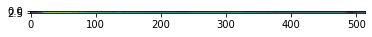

[2021-05-22 10:49:48,065] [INFO] [parse_RGB] [31] : falied to parse roi
[2021-05-22 10:49:48,067] [ERROR] [<module>] [43] : failed to get output from parse_RGB!


(510, 3)
0


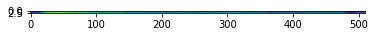

[2021-05-22 10:49:51,237] [INFO] [parse_RGB] [31] : falied to parse roi
[2021-05-22 10:49:51,239] [ERROR] [<module>] [43] : failed to get output from parse_RGB!


(511, 3)
0


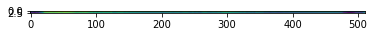

[2021-05-22 10:49:54,326] [INFO] [parse_RGB] [31] : falied to parse roi
[2021-05-22 10:49:54,334] [ERROR] [<module>] [43] : failed to get output from parse_RGB!


(505, 3)
0


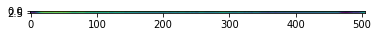

[2021-05-22 10:49:57,591] [INFO] [parse_RGB] [31] : falied to parse roi
[2021-05-22 10:49:57,592] [ERROR] [<module>] [43] : failed to get output from parse_RGB!


(505, 3)
0


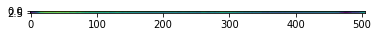

[2021-05-22 10:50:01,943] [INFO] [parse_RGB] [31] : falied to parse roi
[2021-05-22 10:50:01,978] [ERROR] [<module>] [43] : failed to get output from parse_RGB!


KeyboardInterrupt: 

In [173]:
# Parsing video:
for video_location in rotated_video_sources:
    color_sig = [[]]
    heart_rates = []
    good_frame_number = 0
    total_frame_number = 180
    logging.info("Working on video " + video_location)
    vidcap = cv2.VideoCapture(video_location)
    success, image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
    round_fps = np.round(fps)
    number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    logging.info("Parsing images ...")
    skipped_frames = 0
    bad_frames = 0
    max_luminance = 0
    min_luminance = 200
    avg_luminance = 0
    perv_luminance = None
    max_diff_luminance_adjacent = 0

    while success:
        if skipped_frames < 180:
            skipped_frames += 1
            success, image = get_new_frame(vidcap)
            continue
        if total_frame_number % 100 == 0:
            logging.info("Parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
        rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
        if rois is not None :
            roi = np.vstack((rois[0], rois[1]))
            try:
                is_good_frame,color_sig, luminance_level = parse_RGB(roi, color_sig)
                if perv_luminance is not None and luminance_level - perv_luminance > max_diff_luminance_adjacent:
                    max_diff_luminance_adjacent = luminance_level - perv_luminance
                if luminance_level > max_luminance:
                    max_luminance = luminance_level
                if luminance_level < min_luminance:
                    min_luminance = luminance_level
                avg_luminance += luminance_level
                perv_luminance = luminance_level
            except:
                logging.error("failed to get output from parse_RGB!")
                is_good_frame = False
                bad_frames += 1
            if is_good_frame:
                good_frame_number += 1
                #logging.info("luminance level: " + str(luminance_level))
        if roi is None:
            bad_frames += 1
        total_frame_number += 1
        success, image = get_new_frame(vidcap)
    avg_luminance /= total_frame_number
    log_video_details(video_location)
    detect_hr(video_location)
    #except:
    #    logging.warning("Issue in detecting hr in video")

